In [12]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Dict, Any, Tuple, Literal

importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, HoneypotConfigurationNode, FirewallConfigurationNode, NetworkStatusNode, summarize_logs
from state import HoneypotState
nest_asyncio.apply()



def display_graph(graph, width=250, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

In [13]:
def route_message(state: HoneypotState) -> Tuple[Literal["NetworkStatusNode", "FirewallConfigurationNode", "HoneypotConfigurationNode", "summarize", "__end__"], Dict[str, Any]]:
    # Check if we're in final response mode
    if hasattr(state, "tools_completed") and state.tools_completed:
        return END, {}
    
    if hasattr(state, "to_summarize") and state.to_summarize:
        return "summarize", {}

    message = state.messages[-1]

    # Initial tool calls processing
    if not hasattr(state, "pending_tool_calls") or not state.pending_tool_calls:
        if len(message.tool_calls) == 0:
            return END, {}
        pending_tool_calls = list(message.tool_calls)
    else:
        pending_tool_calls = state.pending_tool_calls

    # Process next tool call
    tool_call = pending_tool_calls.pop(0)

    # Determine next node based on tool call
    if tool_call['name'] == "getNetworkStatus":
        next_node = "NetworkStatusNode"
    elif tool_call['name'] == "getFirewallConfiguration":
        next_node = "FirewallConfigurationNode"
    elif tool_call['name'] == "getDockerContainers":
        next_node = "HoneypotConfigurationNode"
    else:
        raise ValueError(f"Unknown tool call: {tool_call['name']}")

    # Determine if all tools have been processed
    tools_completed = not pending_tool_calls

    # Return next node and updated state
    return next_node, {
        "pending_tool_calls": pending_tool_calls,
        "tools_completed": tools_completed
    }


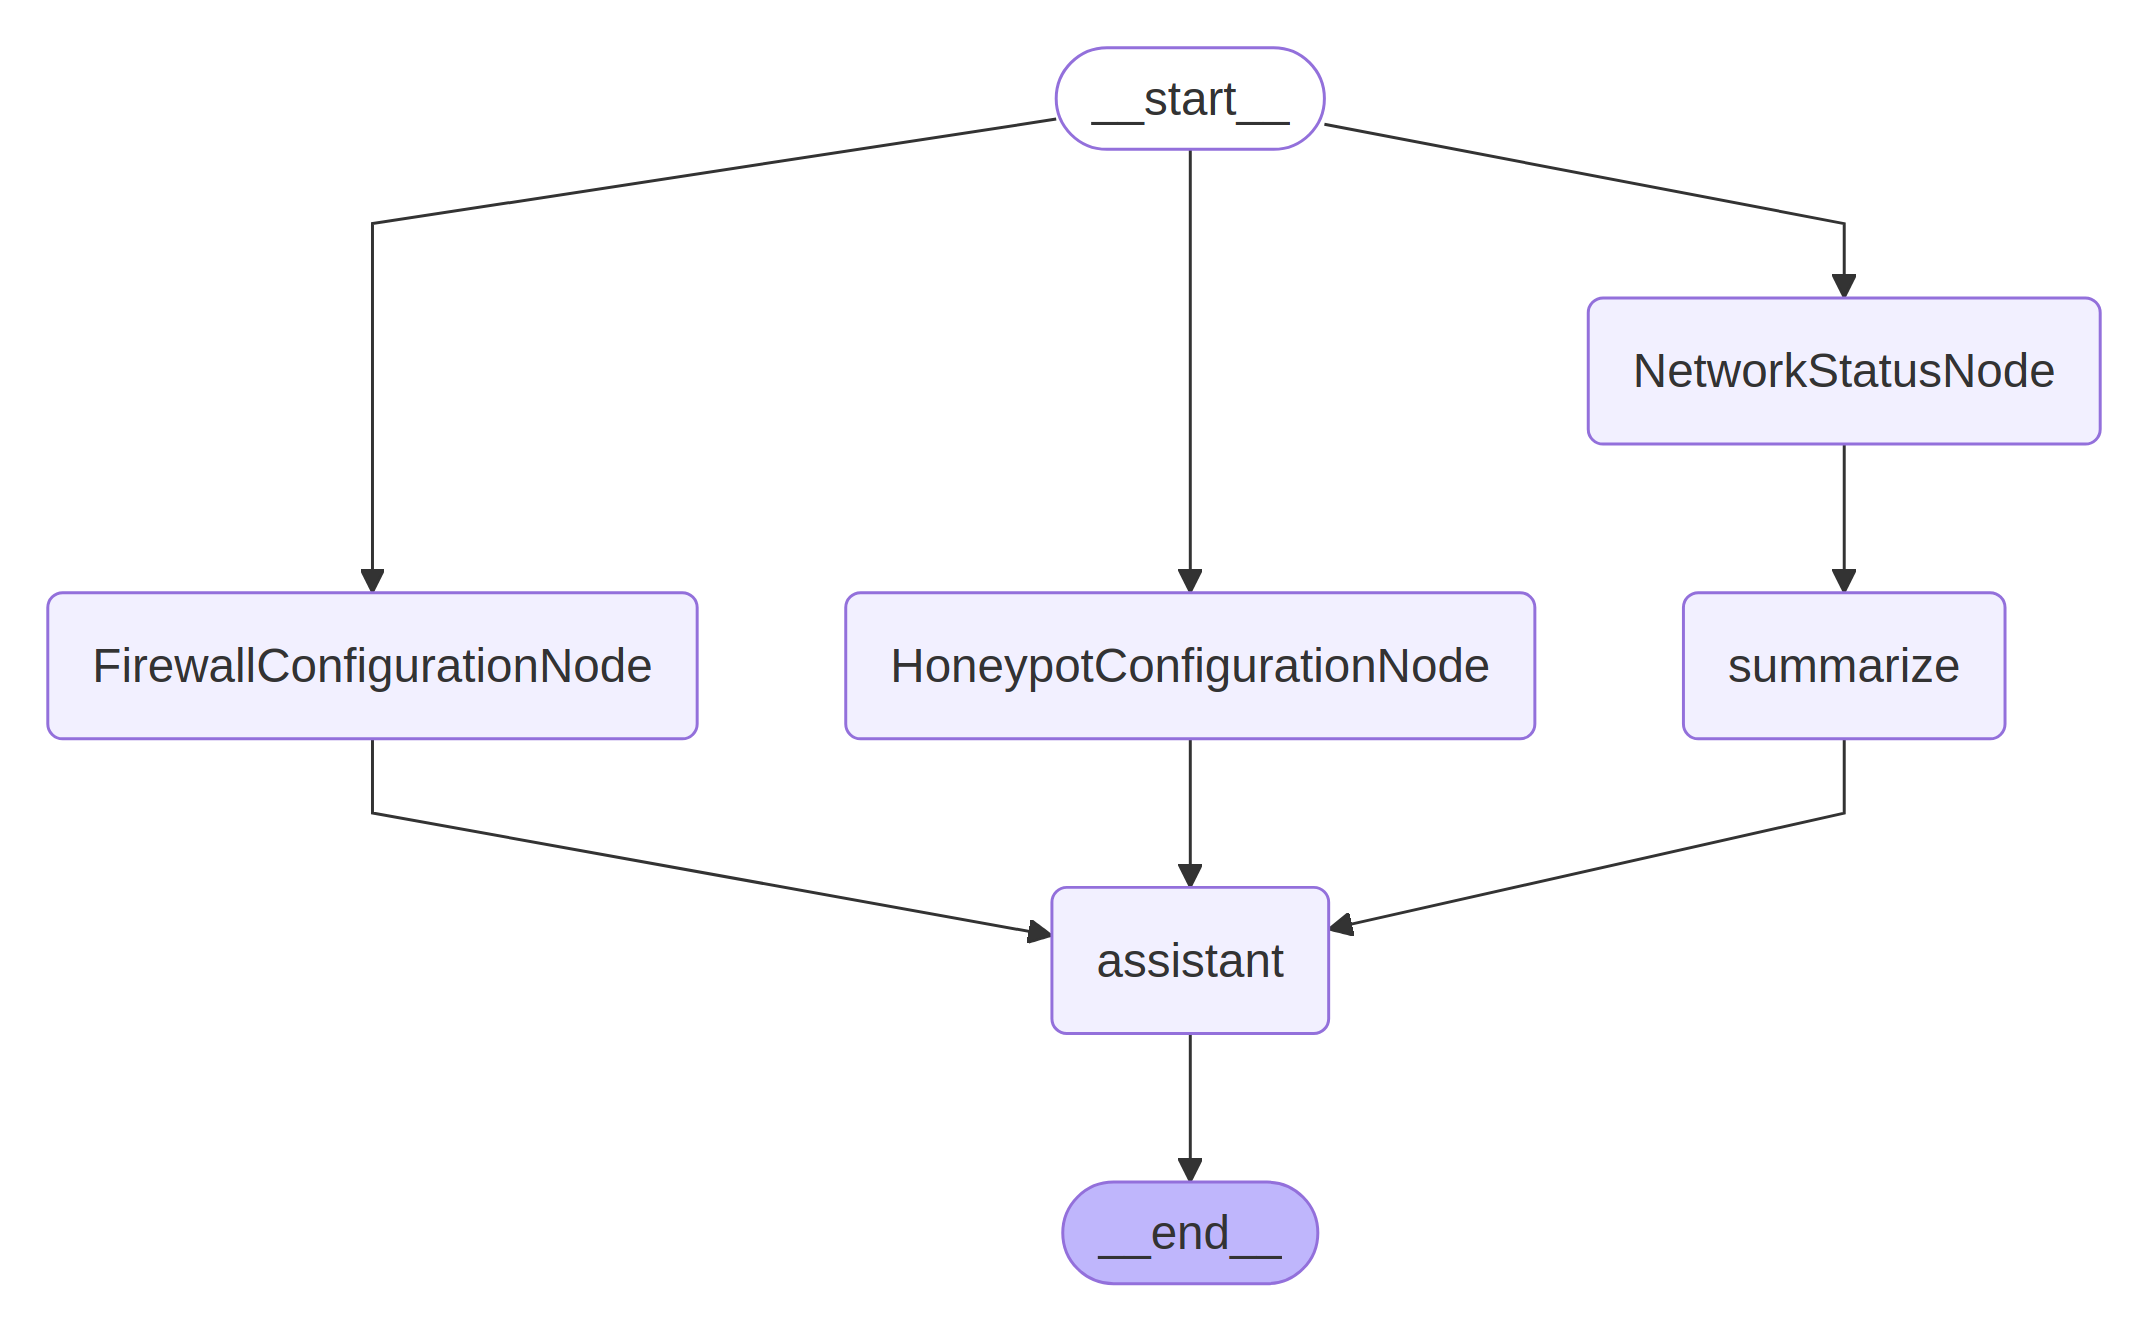

In [14]:

# Graph
builder = StateGraph(HoneypotState)

# # Define nodes: 
def build_graph(builder: StateGraph):
    # Define nodes: 
    builder.add_node("assistant", assistant)
    builder.add_node("FirewallConfigurationNode", FirewallConfigurationNode)
    builder.add_node("NetworkStatusNode", NetworkStatusNode)
    builder.add_node("summarize", summarize_logs)
    builder.add_node("HoneypotConfigurationNode", HoneypotConfigurationNode)

    # Build the graph
    builder.add_edge(START, "FirewallConfigurationNode")
    builder.add_edge(START, "NetworkStatusNode")
    builder.add_edge(START, "HoneypotConfigurationNode")

    builder.add_edge("NetworkStatusNode", "summarize")
    builder.add_edge(["FirewallConfigurationNode", "HoneypotConfigurationNode","summarize"], "assistant")
    builder.add_edge("assistant", END)


build_graph(builder)

graph = builder.compile()
display_graph(graph, width=500, height=500)

In [15]:
# Create an initial state
initial_state = HoneypotState(
    messages = [],  
    network_logs = [],
    firewall_config= "No firewall configuration found",
    honeypotStatus = []
)

response = graph.invoke(initial_state)

Firewall node
Honeypot node
Network node
Setting summarize flag
Summarizing node
Assistant node
Honeypot configuration: [{'id': '643b5f56ac2a', 'name': 'mqtt-honeypot', 'image': 'eclipse-mosquitto:latest', 'status': 'running', 'created': '2025-04-29T08:24:57.451069277Z', 'ports': {'1883/tcp': [{'HostIp': '0.0.0.0', 'HostPort': '1883'}, {'HostIp': '::', 'HostPort': '1883'}], '4444/tcp': [{'HostIp': '0.0.0.0', 'HostPort': '4444'}, {'HostIp': '::', 'HostPort': '4444'}]}, 'ip_address': '172.17.0.4'}, {'id': '409e5a81c226', 'name': 'mssql-honeypot', 'image': 'mcr.microsoft.com/mssql/server:2019-latest', 'status': 'running', 'created': '2025-04-29T08:24:55.508724189Z', 'ports': {'1433/tcp': [{'HostIp': '0.0.0.0', 'HostPort': '1433'}, {'HostIp': '::', 'HostPort': '1433'}]}, 'ip_address': '172.17.0.3'}, {'id': '059b567a9eb3', 'name': 'ssh-honeypot', 'image': 'linuxserver/openssh-server:latest', 'status': 'running', 'created': '2025-04-29T08:24:55.200174208Z', 'ports': {'2222/tcp': [{'HostIp': 

In [17]:
for m in response['messages']:
    m.pretty_print()

    

================================== Ai Message ==================================

Based on the provided network logs, honeypot configuration, and current firewall rules, I will generate a new set of iptables rules to protect the honeypot while strategically engaging potential attackers.

**Analysis of Network Logs:**
- High-frequency IPs `172.17.0.1` and `172.17.0.2` have been identified, suggesting these are aggressively probing the honeypot.
- Port 2222 (SSH) is the primary focus of traffic, with 360 interactions noted, indicating it is being targeted by attackers.
- No geo-location threats or behavioral red flags have been detected, other than the frequency of access which merits attention.

**Honeypot Configuration:**
- There are three containers: MQTT, MSSQL, and SSH, each configured with their respective ports.
- Currently, the logs indicate a significant focus on SSH traffic, but under normal operations, we'd want to rotate exposure.

**Firewall Strategy:**
1. **Rotate Container